In [1]:
#导入库函数
import math
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image

#随机种子
def set_seed(seed):
    seed = int(seed)
    if seed < 0 or seed > (2**32 - 1):
        raise ValueError("Seed must be between 0 and 2**32 - 1")
    else:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
set_seed(16)

#当前设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'使用{device}训练')

使用cuda训练


In [2]:
#数据预处理

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

#定义tranform
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.RandomHorizontalFlip(p=0.5),      # 随机水平翻转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 颜色抖动
    transforms.RandomRotation(degrees=20), # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize([125 / 255, 124 / 255, 115 / 255],
                         [60 / 255, 59 / 255, 64 / 255])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

#训练集：trainset 
trainset = torchvision.datasets.CIFAR10(
    root='/kaggle/input/cnn-cifar-10',  # 数据所在目录（包含cifar-10-batches-py文件夹）
    train=True,
    download=False, 
    transform=transform_train
)

# 测试集：test_batch 
testset = torchvision.datasets.CIFAR10(
    root='/kaggle/input/cnn-cifar-10',
    train=False,
    download=False,
    transform=transform_test
)

#数据加载器
train_loader = DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=128,shuffle=False,num_workers=2)

In [3]:
def ResNet(weights):
    #加载模型,使用 ResNet-18
    model = torchvision.models.resnet18(weights=weights)
    
    #修改第一层卷积
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    #移除池化层
    model.maxpool = nn.Identity()
    
    #替换输出层
    model.fc = nn.Linear(model.fc.in_features, 10)
    
    #冻结
    if weights:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
            
    return model.to(device)
    
model = ResNet(None)
#print(model)

In [4]:
#训练方法和测试方法
from torch.amp import autocast, GradScaler 
if device == 'cuda':    #GPU下使用混合精度
    scaler = GradScaler('cuda') #梯度缩放
    use_amp = True    #使用混合精度
    print("启用混合精度训练")

#训练方法: train
def train():
    model.train()
    total_loss = 0.0 #损失值
    correct = 0 #正确数
    total = 0 #总数
    
    for batch,(X,y) in enumerate(train_loader):
        X,y = X.to(device),y.to(device)

        optimizer.zero_grad()#梯度清零
        #混合精度
        if device == 'cude':
            with autocast('cuda'):#自动转换
                pred = model(X)
                loss = criterion(pred,y)
            scaler.scale(loss).backward() 
            scaler.step(optimizer)
            scaler.update()
        else:
            pred = model(X)
            loss = criterion(pred,y)
            loss.backward()
            optimizer.step()
            
        total_loss += loss.item()  #损失值
        total += y.size(0)  #总数
        pred_index = torch.argmax(pred,dim=1) #最大值索引
        correct += pred_index.eq(y).sum().item() #正确数
    acc = 100. * correct / total #正确率
    loss_ave = total_loss / len(train_loader) #训练损失值取平均
    return loss_ave, acc

#测试方法 test
def test():
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch,(X,y) in enumerate(test_loader):
            X,y = X.to(device),y.to(device)
            pred = model(X)
            loss = criterion(pred,y)
            
            total_loss += loss.item()  #损失值
            total += y.size(0)  #总数
            pred_index = torch.argmax(pred,dim=1) #最大值索引
            correct += pred_index.eq(y).sum().item() #正确数
            
    acc = 100. * correct / total #正确率
    loss_ave = total_loss / len(test_loader) #训练损失值取平均
    return loss_ave, acc
    

启用混合精度训练


In [5]:
#主训练流程
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR
from torch.optim.lr_scheduler import SequentialLR

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) #损失函数
optimizer = optim.SGD(model.parameters(),
                      lr=0.05,               # 初始学习率（关键！）
                      momentum=0.9,
                      weight_decay=5e-4)
epoch = 120
#学习率预热
warmup_step= int(epoch * 0.2)  #预热步数
warmup = LinearLR(optimizer,
                  start_factor=0.01,
                  total_iters=warmup_step)
#余弦退火
cosin = CosineAnnealingLR(optimizer,
                          T_max=epoch - warmup_step)
#调度器
scheduler = SequentialLR(optimizer, 
                         schedulers=[warmup,cosin],#预热然后余弦退火
                         milestones=[warmup_step])#切换

#迭代
train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]
lr_list=[]
best_acc = 90.0 #最高正确率
for i in range(epoch):
    train_loss,train_acc = train()
    test_loss,test_acc = test()
    scheduler.step()  # 更新学习率

    #保存最优模型
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'resnet18_cifar10_best.pth')

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    lr_list.append(scheduler.get_last_lr()[0])
    print("----------------------------------------------")
    print(f'| epoch：{i+1}/{epoch} |\n训练损失值: {train_loss:.3f} | 训练正确率: {train_acc:.2f}% | 测试损失值{test_loss:.3f} | 测试正确率: {test_acc:.2f}% | 学习率: {scheduler.get_last_lr()[0]}')

----------------------------------------------
| epoch：1/120 |
训练损失值: 2.149 | 训练正确率: 21.13% | 测试损失值1.967 | 测试正确率: 29.55% | 学习率: 0.0025625
----------------------------------------------
| epoch：2/120 |
训练损失值: 1.824 | 训练正确率: 36.61% | 测试损失值1.644 | 测试正确率: 45.90% | 学习率: 0.004625000000000001
----------------------------------------------
| epoch：3/120 |
训练损失值: 1.638 | 训练正确率: 46.97% | 测试损失值1.497 | 测试正确率: 54.06% | 学习率: 0.006687500000000002
----------------------------------------------
| epoch：4/120 |
训练损失值: 1.497 | 训练正确率: 54.38% | 测试损失值1.510 | 测试正确率: 55.56% | 学习率: 0.00875
----------------------------------------------
| epoch：5/120 |
训练损失值: 1.392 | 训练正确率: 59.84% | 测试损失值1.375 | 测试正确率: 62.67% | 学习率: 0.010812500000000001
----------------------------------------------
| epoch：6/120 |
训练损失值: 1.303 | 训练正确率: 64.35% | 测试损失值1.249 | 测试正确率: 67.90% | 学习率: 0.012875000000000001
----------------------------------------------
| epoch：7/120 |
训练损失值: 1.233 | 训练正确率: 67.80% | 测试损失值1.160 | 测试正确率: 72.47% | 学习率: 0.

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


----------------------------------------------
| epoch：25/120 |
训练损失值: 0.847 | 训练正确率: 84.99% | 测试损失值0.855 | 测试正确率: 84.92% | 学习率: 0.049986614686909146
----------------------------------------------
| epoch：26/120 |
训练损失值: 0.847 | 训练正确率: 84.94% | 测试损失值0.862 | 测试正确率: 84.40% | 学习率: 0.049946473080965094
----------------------------------------------
| epoch：27/120 |
训练损失值: 0.831 | 训练正确率: 85.65% | 测试损失值0.850 | 测试正确率: 84.82% | 学习率: 0.04987961816680493
----------------------------------------------
| epoch：28/120 |
训练损失值: 0.829 | 训练正确率: 85.70% | 测试损失值0.970 | 测试正确率: 80.74% | 学习率: 0.04978612153434527
----------------------------------------------
| epoch：29/120 |
训练损失值: 0.824 | 训练正确率: 85.92% | 测试损失值0.895 | 测试正确率: 83.28% | 学习率: 0.04966608330212199
----------------------------------------------
| epoch：30/120 |
训练损失值: 0.819 | 训练正确率: 86.05% | 测试损失值0.819 | 测试正确率: 86.32% | 学习率: 0.04951963201008077
----------------------------------------------
| epoch：31/120 |
训练损失值: 0.818 | 训练正确率: 86.13% | 测试损失值0.85

最高学习率: 94.99


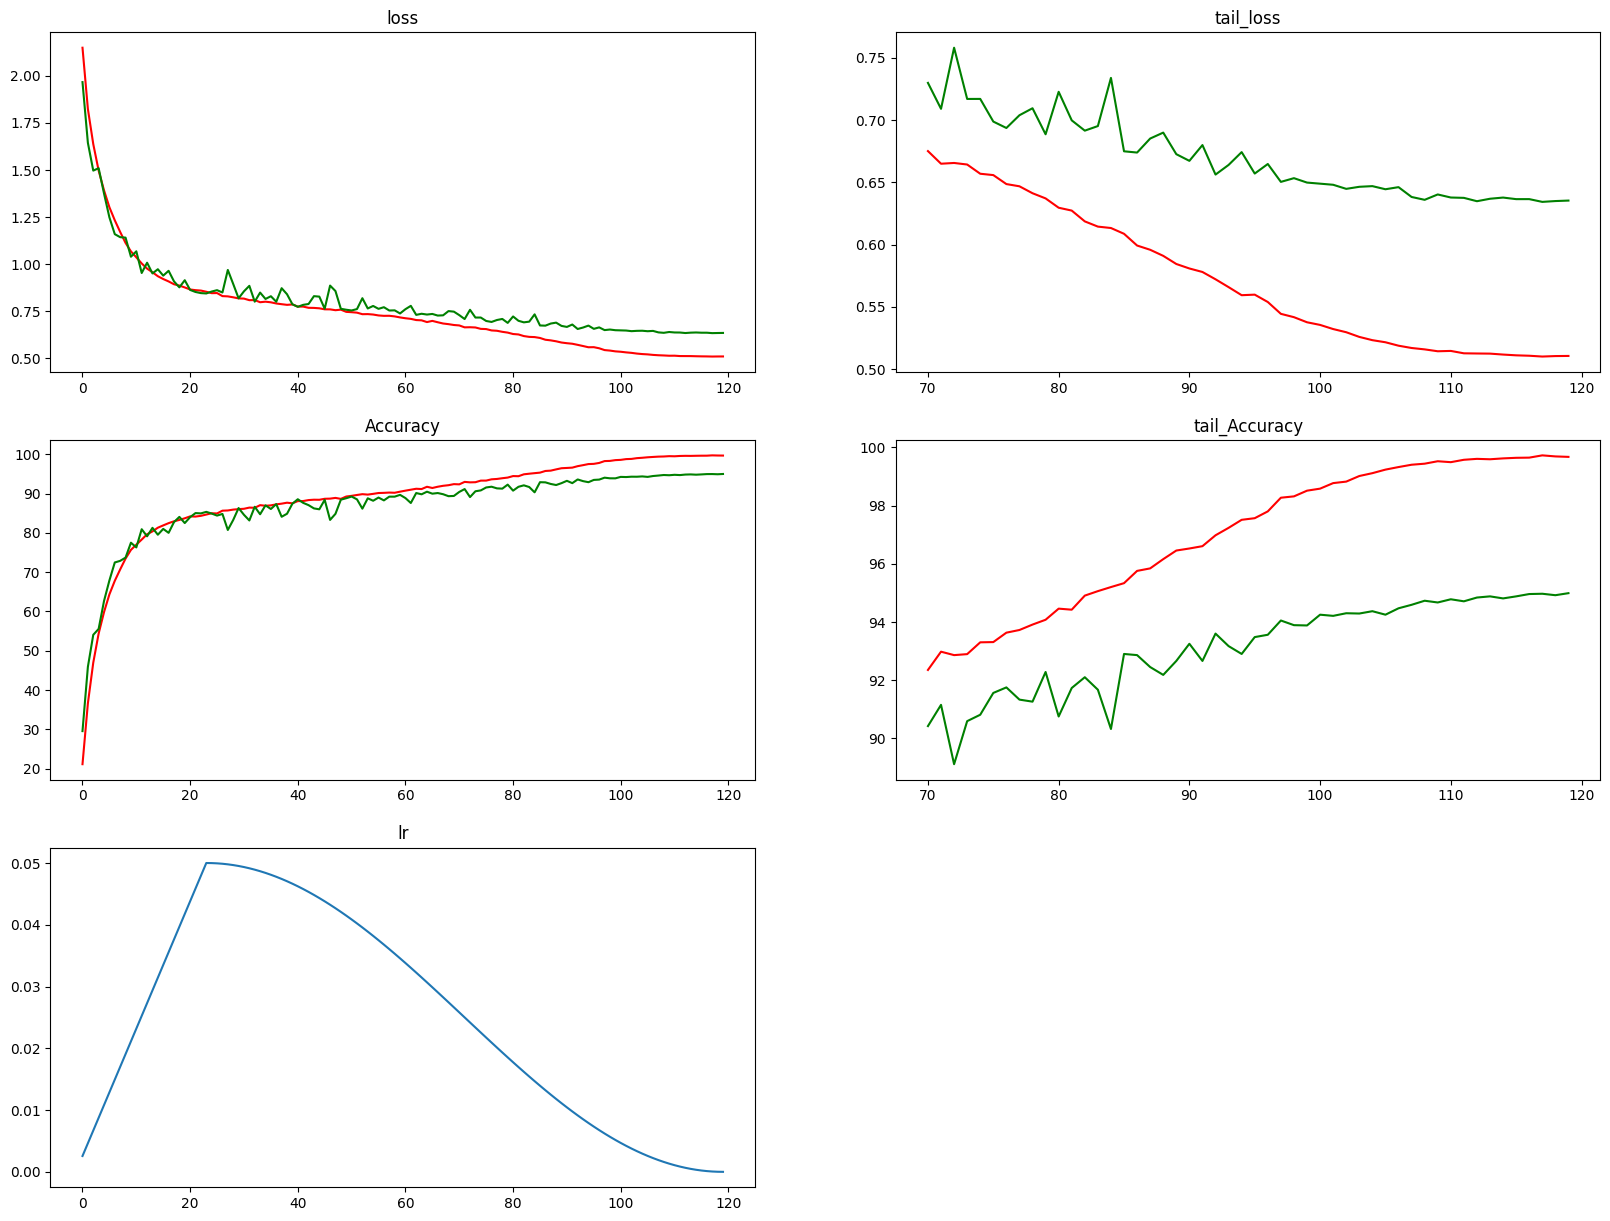

In [6]:
#可视化
print(f'最高学习率: {best_acc}')
x=[i for i in range(epoch)]

plt.figure(figsize=(20,15))

plt.subplot(3,2,1)
plt.plot(x,train_loss_list,color='red',label='train_loss')
plt.plot(x,test_loss_list,color='green',label='test_loss')
plt.title("loss")

plt.subplot(3,2,2)
plt.plot(x[-50:],train_loss_list[-50:],color='red',label='train_loss')
plt.plot(x[-50:],test_loss_list[-50:],color='green',label='test_loss')
plt.title("tail_loss")

plt.subplot(3,2,3)
plt.plot(x,train_acc_list,color='red',label='train_loss')
plt.plot(x,test_acc_list,color='green',label='test_loss')
plt.title("Accuracy")

plt.subplot(3,2,4)
plt.plot(x[-50:],train_acc_list[-50:],color='red',label='train_loss')
plt.plot(x[-50:],test_acc_list[-50:],color='green',label='test_loss')
plt.title("tail_Accuracy")

plt.subplot(3,2,5)
plt.plot(lr_list)
plt.title("lr")

plt.show()

In [7]:
#使用最优模型输出结果
import pandas as pd
#读取模型参数
model.load_state_dict(torch.load("/kaggle/working/resnet18_cifar10_best.pth"))
model.eval()
res=[]
with torch.no_grad():        
    for inputs,targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        #拼接结果
        if res == []:
            res = outputs.argmax(1)
        else:res = torch.cat((res,outputs.argmax(1)),dim=0)

ID=[i for i in range(0,10000)]
res=res.to('cpu').numpy()
result=pd.DataFrame({
    'Id':ID,
    'label':res
    })
#输出结果
result.to_csv('result.csv',index=False)